In [1]:
import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from pprint import pprint
import spacy
import pickle
import re 
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt 
import pandas as pd
import os

# 1. Body text

In [2]:
# prepare data
directory = 'output/unprocessed/body/'
documents = []
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file

    if (os.path.isfile(f) and (".DS_Store" not in f)):
        # print(f)
        with open(f, 'r', encoding="utf8") as fp:
            currentfiledata = fp.read()
        documents.append(currentfiledata.lower())

In [3]:
# be sure to split text in each document into tokens before feeding into Dictionary
from nltk.corpus import stopwords
en_stopwords = stopwords.words('english')

def remove_stopwords(text):
    result = []
    for token in text:
        if token not in en_stopwords:
            result.append(token)
            
    return result

from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
  
ps = PorterStemmer()

def stemwords(words):
    global ps
    result = []
    for word in words:
        result.append(ps.stem(word))
    return result

documents2 = [stemwords(remove_stopwords(doc.split())) for doc in documents]
id2word = Dictionary(documents2)
# Term Document Frequency
corpus = [id2word.doc2bow(doc) for doc in documents2]

In [4]:
# Build LDA model
lda_model = LdaModel(corpus=corpus,
                   id2word=id2word,
                   num_topics=20, 
                   random_state=0,
                   chunksize=100,
                   alpha='auto',
                   per_word_topics=True)

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.028*"water" + 0.010*"." + 0.007*"oecd" + 0.006*"manag" + 0.005*"use" + '
  '0.005*"polici" + 0.004*"resourc" + 0.003*"govern" + 0.003*"•" + '
  '0.003*"also"'),
 (1,
  '0.030*"water" + 0.006*"manag" + 0.005*"govern" + 0.004*"polici" + '
  '0.004*"cost" + 0.004*"oecd" + 0.004*"level" + 0.004*"use" + 0.004*"river" + '
  '0.004*"develop"'),
 (2,
  '0.041*"water" + 0.006*"." + 0.006*"govern" + 0.006*"manag" + 0.006*"polici" '
  '+ 0.005*"oecd" + 0.005*"use" + 0.004*"level" + 0.004*"resourc" + '
  '0.003*"develop"'),
 (3,
  '0.025*"water" + 0.008*"manag" + 0.006*"govern" + 0.005*"use" + '
  '0.005*"polici" + 0.004*"develop" + 0.004*"resourc" + 0.004*"oecd" + '
  '0.004*"provid" + 0.004*"cost"'),
 (4,
  '0.032*"water" + 0.006*"manag" + 0.005*"use" + 0.005*"oecd" + 0.005*"." + '
  '0.005*"polici" + 0.004*"•" + 0.004*"govern" + 0.004*"resourc" + '
  '0.004*"sanit"'),
 (5,
  '0.031*"water" + 0.007*"govern" + 0.007*"use" + 0.006*"oecd" + 0.006*"manag" '
  '+ 0.005*"resourc" + 0.004*"•"

In [5]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=documents2, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\\nCoherence Score: ', coherence_lda)

\nCoherence Score:  0.2816229693749455


In [6]:
# Try mallet LDA model (tends to have better topic coherence scores)
os.environ.update({'MALLET_HOME':r'mallet-2.0.8'})
mallet_path = r'mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=documents2, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('financ', 0.018924175072661992),
   ('privat', 0.012181569499059668),
   ('sanit', 0.012101427594460592),
   ('water', 0.011663318515985639),
   ('sector', 0.011503034706787485),
   ('invest', 0.011091639596512224),
   ('develop', 0.010755043597196102),
   ('servic', 0.01034899128056078),
   ('project', 0.010215421439562318),
   ('financi', 0.008083646777226876)]),
 (1,
  [('water', 0.049512340487158205),
   ('state', 0.01788549052809821),
   ('basin', 0.014303936367535412),
   ('resourc', 0.013964162178119657),
   ('charg', 0.013435005653619709),
   ('river', 0.011925517041625124),
   ('alloc', 0.009391135792704324),
   ('de', 0.009123772496114877),
   ('•', 0.008667026864441239),
   ('–', 0.007118547771694025)]),
 (2,
  [('pollut', 0.02126631222812953),
   ('qualiti', 0.012113339777670372),
   ('environment', 0.01142862896729499),
   ('pharmaceut', 0.009213388110198163),
   ('treatment', 0.007350571934912196),
   ('al.,', 0.007249879168680522),
   ('sourc', 0.007068632189463

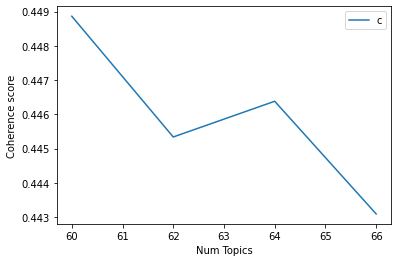

In [7]:
# compute optimal number of topics (max topic coherence scores)
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=documents2, start=60, limit=68, step=2)

# Show graph
limit=68; start=60; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [8]:
# compute the model with the optimal coherence score
best_result_index = coherence_values.index(max(coherence_values))
optimal_model = model_list[best_result_index]
# Select the model and print the topics
model_topics = optimal_model.show_topics(formatted=False)
print(f'''The {x[best_result_index]} topics gives the highest coherence score \\
of {coherence_values[best_result_index]}''')

The 60 topics gives the highest coherence score \
of 0.4488620950638958


In [9]:
# Convert Mallet model to vanilla LDA model so that we can visualize it using PYLDavis
def convertldaGenToldaMallet(mallet_model):
    model_gensim = LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha, eta=0,
    )
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

optimal_model = convertldaGenToldaMallet(optimal_model)

In [10]:
# plot topics for optimal LDA model
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(optimal_model, corpus, id2word, R=10)
p

/Users/kodymoodley/Documents/local-coding/topic-modelling-ctm/ctmenv/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/Users/kodymoodley/Documents/local-coding/topic-modelling-ctm/ctmenv/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/kodymoodley/Documents/local-coding/topic-modelling-ctm/ctmenv/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
24    -0.042742 -0.087989       1        1  10.610436
45    -0.115465 -0.149422       2        1   9.882271
17    -0.104372 -0.187969       3        1   6.594418
23    -0.018306 -0.054988       4        1   5.885821
0     -0.175533 -0.091819       5        1   5.501772
59     0.061421 -0.181330       6        1   4.113197
48    -0.174554 -0.025232       7        1   3.104148
56    -0.024323 -0.205304       8        1   3.022938
16    -0.050906 -0.113591       9        1   2.705578
11     0.021928 -0.176409      10        1   2.595535
6     -0.128737  0.088028      11        1   1.935112
20    -0.106166  0.121324      12        1   1.929960
39    -0.144763  0.005790      13        1   1.606784
13    -0.055468  0.034825      14        1   1.467829
8     -0.075724  0.038288      15        1   1.433339
57    -0.022397 -0.119281      16        1   1.433167
21    -0.092739 -0.068678      17        1   1.422589
49     0.052388 -0.014794      18        1   1.420084
7      0.028295 -0.008489      19        1   1.400176
42    -0.067470 -0.072051      20        1   1.384636
9      0.132689 -0.069317      21        1   1.312311
12    -0.115659 -0.036927      22        1   1.198277
15    -0.135040  0.061680      23        1   1.169117
58    -0.142499  0.048431      24        1   1.167346
25     0.111522  0.013759      25        1   1.108877
5      0.036155  0.091923      26        1   1.068088
4     -0.223460  0.008469      27        1   1.053651
46     0.122514 -0.050774      28        1   1.010797
36    -0.096875  0.119568      29        1   1.002226
47    -0.147546 -0.023388      30        1   0.975688
28    -0.046634 -0.021065      31        1   0.954159
44     0.056503 -0.108746      32        1   0.953585
31     0.009539  0.079452      33        1   0.925805
27    -0.033377  0.047040      34        1   0.888635
38     0.044838 -0.021196      35        1   0.858016
2      0.116755 -0.017574      36        1   0.856083
52     0.071471 -0.158407      37        1   0.849257
29     0.027573  0.095744      38        1   0.846670
30     0.001880  0.057677      39        1   0.813368
32     0.086171  0.137432      40        1   0.792344
53     0.081952  0.119729      41        1   0.767702
54     0.182633  0.059819      42        1   0.761647
10     0.031958  0.053626      43        1   0.664453
51     0.075512  0.142796      44        1   0.655934
22    -0.078134  0.069869      45        1   0.654502
3     -0.091374  0.139990      46        1   0.616460
26     0.123439  0.094571      47        1   0.593436
43     0.092320  0.055984      48        1   0.592642
19     0.104541 -0.145264      49        1   0.581811
14     0.119023 -0.089087      50        1   0.567410
55    -0.055031  0.142354      51        1   0.528524
35     0.102423  0.057484      52        1   0.512207
34     0.175540 -0.010300      53        1   0.502323
33     0.168644 -0.109825      54        1   0.488182
18    -0.070217  0.079885      55        1   0.484452
40     0.134929 -0.040515      56        1   0.476151
50     0.090524  0.027149      57        1   0.457765
41     0.041187  0.101923      58        1   0.352683
37     0.067876  0.108650      59        1   0.346041
1      0.061365  0.156472      60        1   0.141587, topic_info=             Term          Freq         Total Category  logprob  loglift
5049        water  78829.000000  78829.000000  Default  10.0000  10.0000
10960           .   9932.000000   9932.000000  Default   9.0000   9.0000
5190            •   9410.000000   9410.000000  Default   8.0000   8.0000
3778         oecd  12396.000000  12396.000000  Default   7.0000   7.0000
3518        manag  13591.000000  13591.000000  Default   6.0000   6.0000
...           ...           ...           ...      ...      ...      ...
2411      denmark     11.352256    195.003774  Topic60  -5.5773   3.7164
8257   standardis     10.